## Turnstile Jump Detection:  
- A proof of concept classifier which classifies each image as person <b>jumping</b> or <b>walking.</b>
- About 100 images of people walking 100 images of people jumping are used to train classifier.
- [OpenPose](https://github.com/CMU-Perceptual-Computing-Lab/openpose) is used to extract 18 key point on human body for each image.
- Random Forest Classifier is trained on these key points after some feature engineering. (default hyperparameters)

- Classifier gives about 90% accuracy even with a train/test split of 50/50 indicating that it is an easy classification problem.

<b> Results Visualized in the End of notebook.</b>

In [3]:
import argparse
import logging
import sys
import time

from tf_pose import common
import cv2
import numpy as np
from tf_pose.estimator import TfPoseEstimator
from tf_pose.networks import get_graph_path, model_wh
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'tf_pose'

In [20]:
import pylab
import seaborn as sns

## Loading OpenPose Model

In [3]:
size = '432x368'
model = 'mobilenet_thin'

In [4]:
w, h = model_wh(size)
if w == 0 or h == 0:
    e = TfPoseEstimator(get_graph_path(model), target_size=(432, 368))
else:
    e = TfPoseEstimator(get_graph_path(model), target_size=(w, h))

[2018-12-13 02:55:07,969] [TfPoseEstimator] [INFO] loading graph from /home/urwa/Documents/PoseProject/tf-openpose/models/graph/mobilenet_thin/graph_opt.pb(default size=432x368)


## Loading Jumping pose Images

In [5]:
import os
import pandas as pd

In [6]:
jumpDir = '/home/urwa/Documents/images/jump/'
jumpimages = os.listdir(jumpDir)

In [7]:
jumpHumans = []
jumpFiles=[]
for img in jumpimages:
    image = common.read_imgfile(jumpDir+img, None, None)
    humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
    if len(humans)>0:
        jumpHumans.append(humans[0])
        jumpFiles.append(image)

## Loading Standing pose Images

In [2]:
standDir = '/home/urwa/Documents/images/stand/'
standimages = os.listdir(standDir)

NameError: name 'os' is not defined

In [1]:
standHumans = []
standFiles = []
for img in standimages:
    #print(img)
    image = common.read_imgfile(standDir+img, None, None)
    humans = e.inference(image, resize_to_default=(w > 0 and h > 0), upsample_size=4.0)
    if len(humans)>0:
        standHumans.append(humans[0])
        standFiles.append(image)

NameError: name 'standimages' is not defined

## Extract Features

In [10]:
def humanToDict(hum):
    resultDict = {}
    parts = hum.body_parts.keys()
    for p in parts:
        resultDict[str(p)+'_x'] = hum.body_parts[p].x
        resultDict[str(p)+'_y'] = hum.body_parts[p].y
        #resultDict[str(p)+'_p'] = hum.body_parts[p].p
    return resultDict

In [11]:
standHumanList = []
for sh in standHumans:
    standHumanList.append(humanToDict(sh))

In [12]:
jumpHumanList = []
for jh in jumpHumans:
    jumpHumanList.append(humanToDict(jh))

In [13]:
standHumadf = pd.DataFrame(standHumanList)
#standHumadf['img'] = standFiles
standHumadf.head()

0_x       0_y      10_x      10_y      11_x      11_y      12_x  \
0  0.675926  0.141304  0.856481  0.858696  0.699074  0.489130  0.592593   
1  0.472222  0.163043  0.476852  0.864130  0.611111  0.451087  0.611111   
2  0.523148  0.130435  0.518519  0.902174  0.569444  0.483696  0.560185   
3  0.546296  0.114130  0.421296  0.847826  0.578704  0.489130  0.537037   
4  0.472222  0.092391  0.296296  0.820652  0.495370  0.423913  0.486111   

       12_y      13_x      13_y    ...          5_x       5_y       6_x  \
0  0.673913       NaN       NaN    ...     0.768519  0.228261  0.851852   
1  0.657609  0.597222  0.875000    ...     0.569444  0.222826  0.648148   
2  0.690217  0.550926  0.869565    ...     0.587963  0.217391  0.606481   
3  0.695652  0.504630  0.907609    ...     0.597222  0.211957  0.601852   
4  0.646739  0.486111  0.836957    ...     0.564815  0.206522  0.601852   

        6_y       7_x       7_y       8_x       8_y       9_x       9_y  
0  0.353261  0.879630  0.461957  0.648148  0.483696  0.754630  0.690217  
1  0.260870  0.564815  0.190217  0.486111  0.451087  0.481481  0.673913  
2  0.347826  0.611111  0.461957  0.504630  0.483696  0.513889  0.690217  
3  0.375000  0.620370  0.478261  0.518519  0.489130  0.513889  0.695652  
4  0.320652  0.574074  0.445652  0.351852  0.413043  0.324074  0.646739  

[5 rows x 36 columns]

In [16]:
#standHumadf.isna().sum()

In [17]:
jumpHumadf = pd.DataFrame(jumpHumanList)
jumpHumadf.head()

0_x       0_y      10_x     10_y      11_x      11_y      12_x  \
0  0.541667  0.222826       NaN      NaN  0.578704  0.505435  0.680556   
1  0.402778  0.146739       NaN      NaN  0.476852  0.456522  0.412037   
2       NaN       NaN       NaN      NaN  0.578704  0.429348  0.625000   
3  0.361111  0.293478       NaN      NaN  0.407407  0.500000  0.486111   
4  0.486111  0.206522  0.347222  0.88587  0.537037  0.603261  0.671296   

       12_y      13_x      13_y    ...          5_x       5_y       6_x  \
0  0.554348       NaN       NaN    ...     0.638889  0.282609  0.671296   
1  0.614130       NaN       NaN    ...     0.467593  0.217391  0.541667   
2  0.500000  0.500000  0.635870    ...     0.685185  0.413043       NaN   
3  0.483696  0.421296  0.646739    ...     0.416667  0.298913  0.500000   
4  0.586957  0.574074  0.853261    ...     0.546296  0.282609  0.606481   

        6_y       7_x       7_y       8_x       8_y       9_x       9_y  
0  0.423913  0.620370  0.451087  0.402778  0.500000  0.462963  0.657609  
1  0.233696  0.634259  0.250000  0.435185  0.461957       NaN       NaN  
2       NaN       NaN       NaN  0.541667  0.418478  0.495370  0.489130  
3  0.244565  0.560185  0.179348  0.361111  0.500000       NaN       NaN  
4  0.467391  0.578704  0.586957  0.379630  0.586957  0.324074  0.625000  

[5 rows x 36 columns]

In [18]:
jumpHumadf.shape

(114, 36)

In [19]:
#jumpHumadf.isna().sum()

## Join positive and negative examples into one DataFrame

In [21]:
jumpHumadf['pose']=1
standHumadf['pose']=0
alldata = jumpHumadf.append(standHumadf)
alldata = alldata.reset_index(drop = True)
alldata.shape

(207, 37)

In [22]:
allFiles = jumpFiles + standFiles 
allHumans = jumpHumans + standHumans

In [24]:
def min_max_normalize(df):
    xcols = [c for c in df.columns if 'x' in c]
    xdf = df[xcols]
    xdf = xdf.subtract(xdf.min(axis=1), axis=0)
    xdf = xdf.divide(xdf.max(axis=1), axis=0)
    
    ycols = [c for c in df.columns if 'y' in c]
    ydf = df[ycols]
    ydf = ydf.subtract(ydf.min(axis=1), axis=0)
    ydf = ydf.divide(ydf.max(axis=1), axis=0)
    
    resultdf =  pd.concat( [xdf,ydf, df[['pose']]], axis=1 )
    return resultdf

In [25]:
alldata = min_max_normalize(alldata)
#alldata

### Model

In [26]:
from sklearn.ensemble  import RandomForestClassifier as rfc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [27]:
alldata.head(2)

0_x  10_x      11_x      12_x  13_x      14_x      15_x      16_x  \
0  0.600000   NaN  0.706667  1.000000   NaN  0.520000  0.666667  0.440000   
1  0.324324   NaN  0.540541  0.351351   NaN  0.283784  0.351351  0.256757   

       17_x       1_x  ...        1_y       2_y       3_y       4_y       5_y  \
0  0.813333  0.600000  ...   0.180723  0.156627  0.301205  0.493976  0.168675   
1  0.405405  0.378378  ...   0.213483  0.235955  0.303371  0.303371  0.179775   

        6_y       7_y       8_y  9_y  pose  
0  0.481928  0.542169  0.650602  1.0     1  
1  0.213483  0.247191  0.685393  NaN     1  

[2 rows x 37 columns]

In [28]:
treatData = alldata.copy()

## Replacing missing with sentinel value

In [30]:
treatData = treatData.fillna(-1)

## Training a Random Forest and Predicting for Test Set (split: 70/30)

In [41]:
X = treatData[[c for c in treatData.columns if c != 'pose']]
X['img'] = allFiles
X['human'] = allHumans
Y = treatData['pose']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=2018, shuffle=True)

testImg = X_test.img
testHuman = X_test.human
X_train = np.array(X_train[[c for c in X_train.columns if c not in ['img','human'] and 'x' not in c]]) 
X_test = np.array(X_test[[c for c in X_test.columns if c not in ['img','human'] and 'x' not in c]]) 

print(X_train.shape)

clf = rfc()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

(144, 18)
              precision    recall  f1-score   support

           0       0.96      0.86      0.91        28
           1       0.89      0.97      0.93        35

   micro avg       0.92      0.92      0.92        63
   macro avg       0.93      0.91      0.92        63
weighted avg       0.92      0.92      0.92        63



/home/urwa/miniconda3/envs/pose/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## Displaying Test Images with Prediction for Visual Validation

/home/urwa/miniconda3/envs/pose/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


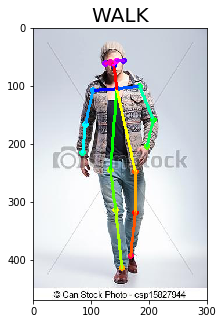

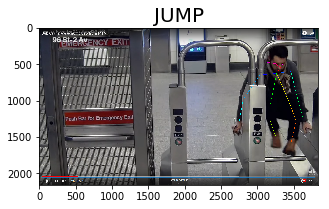

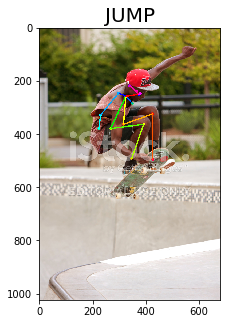

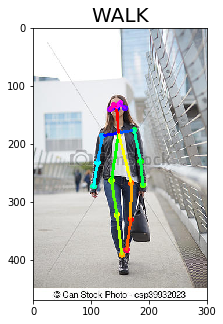

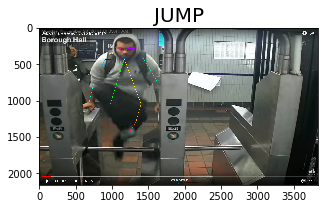

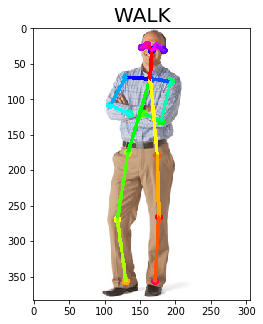

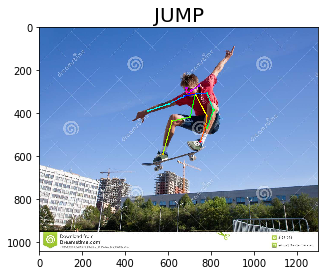

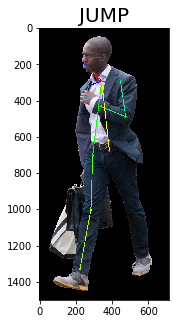

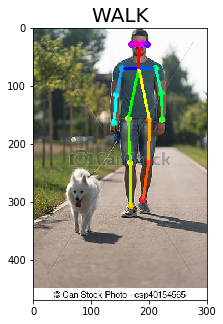

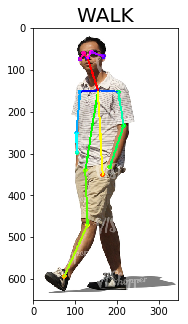

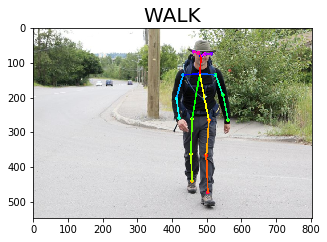

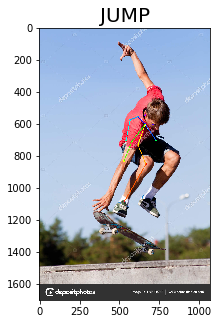

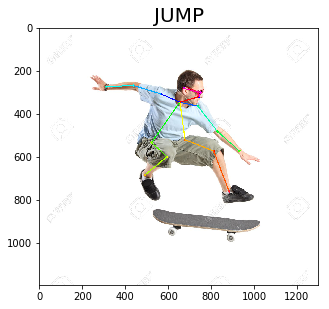

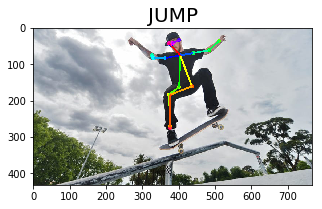

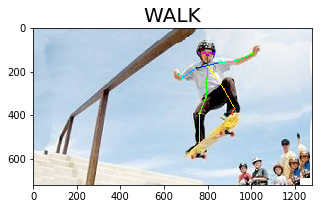

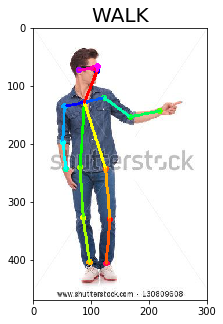

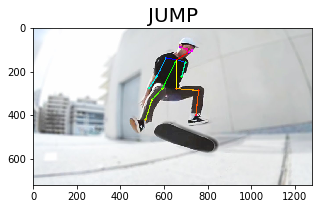

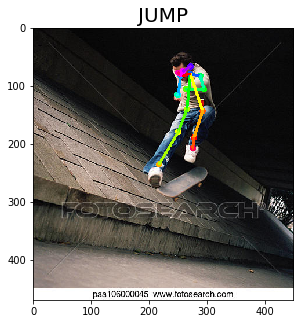

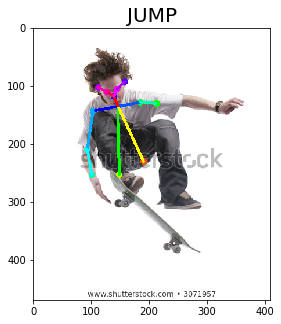

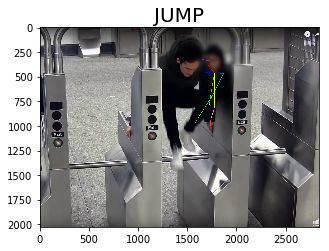

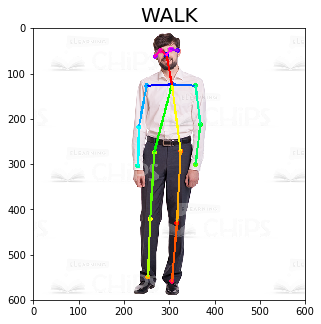

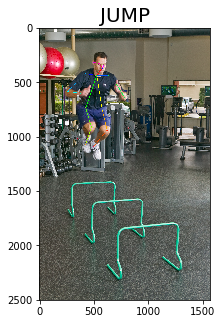

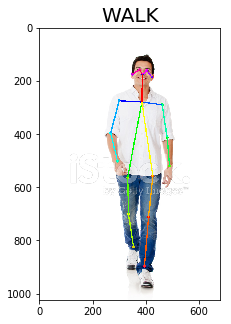

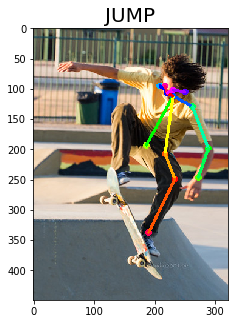

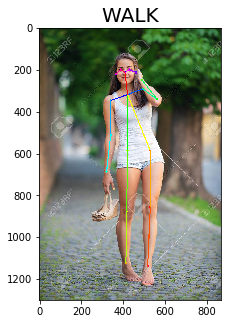

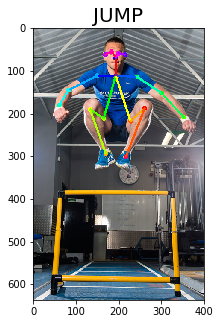

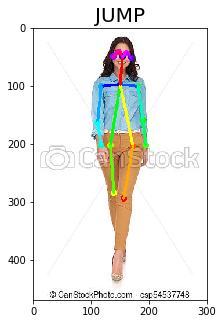

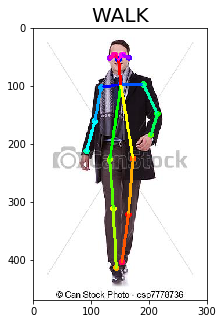

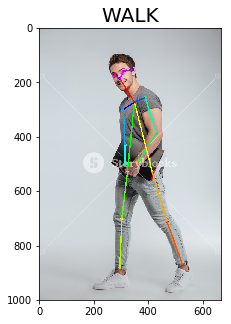

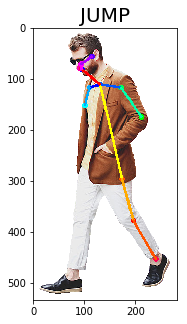

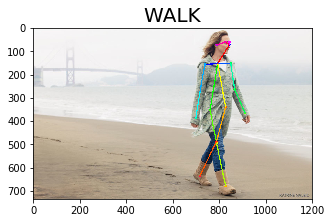

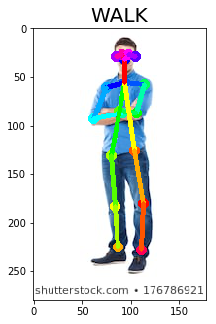

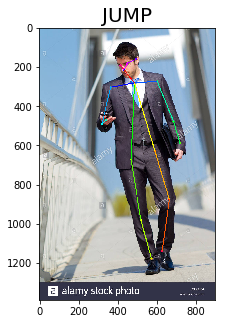

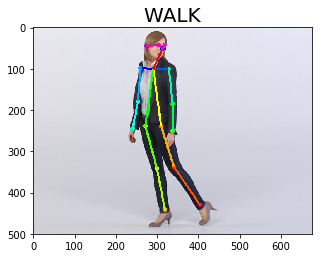

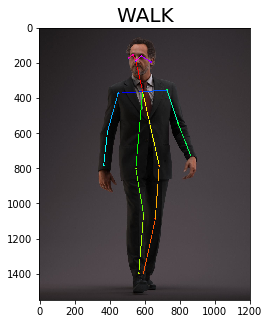

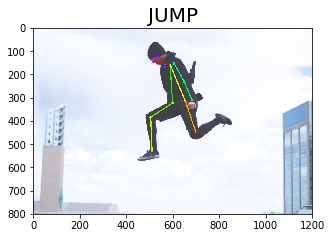

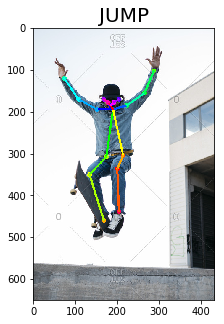

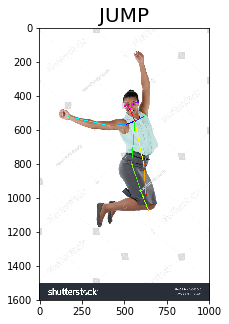

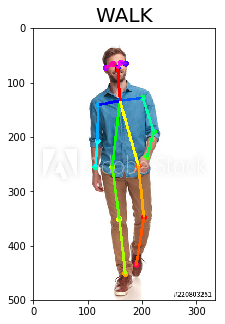

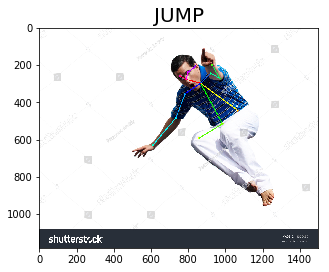

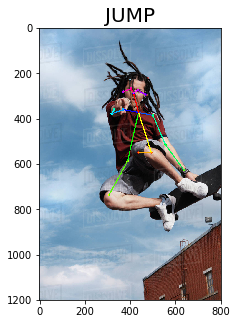

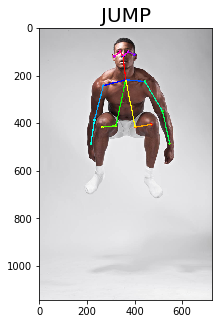

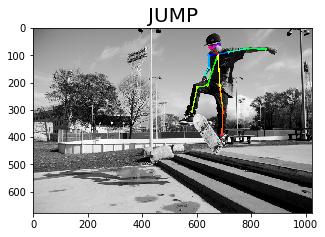

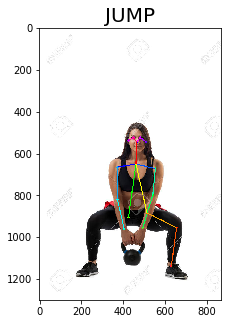

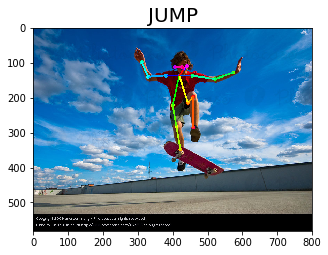

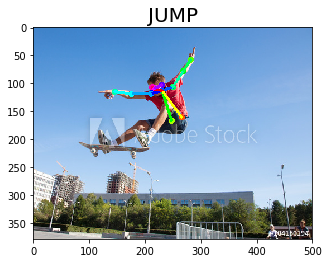

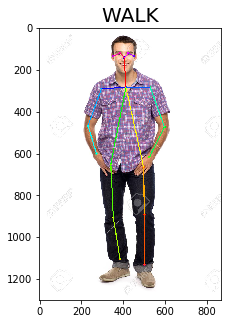

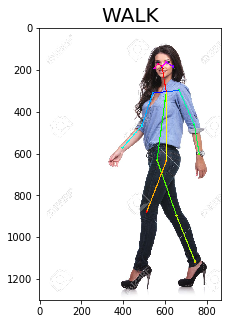

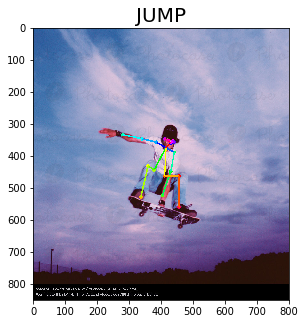

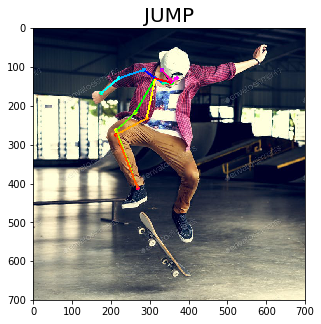

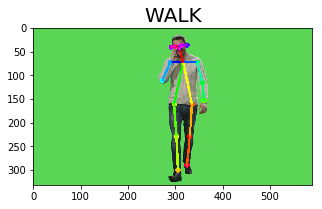

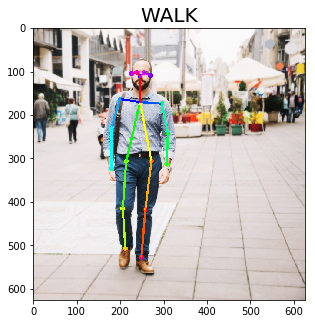

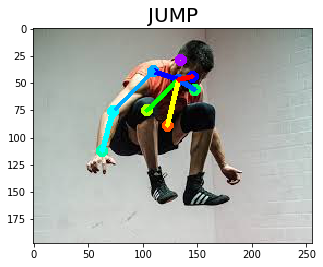

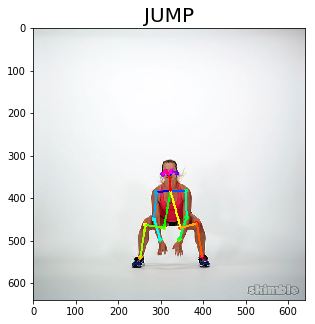

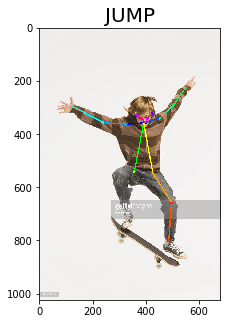

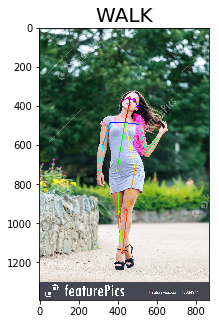

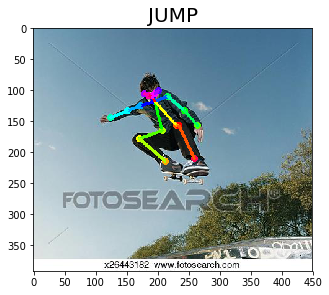

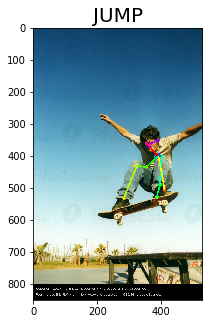

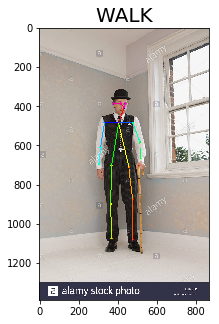

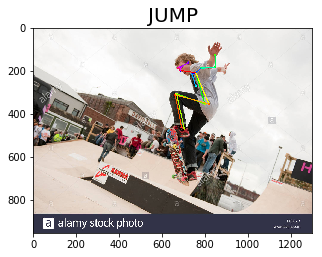

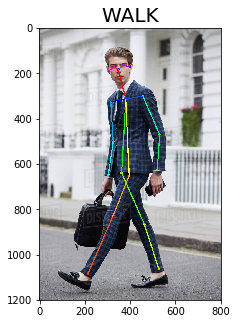

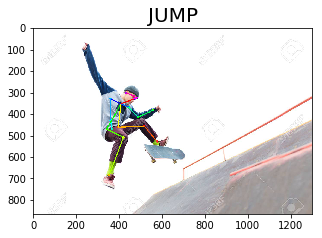

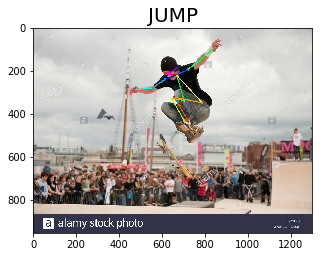

In [42]:
for p,img,hum in zip(y_pred,testImg,testHuman):
    fig = plt.figure(figsize = (5,5))
    a = fig.add_subplot(1, 1, 1)
    if(p):
        t='JUMP'
    else:
        t='WALK'
    a.set_title(t,fontsize=20)
    resultImage = TfPoseEstimator.draw_humans(img, [hum], imgcopy=False)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Feature ranking:
1. feature 0_x (0.178730)
2. feature 1_x (0.147193)
3. feature 15_x (0.107104)
4. feature 8_x (0.084366)
5. feature 11_x (0.082273)
6. feature 2_x (0.068325)
7. feature 9_x (0.067366)
8. feature 3_x (0.055055)
9. feature 14_x (0.045560)
10. feature 12_x (0.040355)
11. feature 7_x (0.028205)
12. feature 4_x (0.026271)
13. feature 5_x (0.024991)
14. feature 6_x (0.014862)
15. feature 16_x (0.012341)
16. feature 13_x (0.007353)
17. feature 10_x (0.006857)
18. feature 17_x (0.002791)


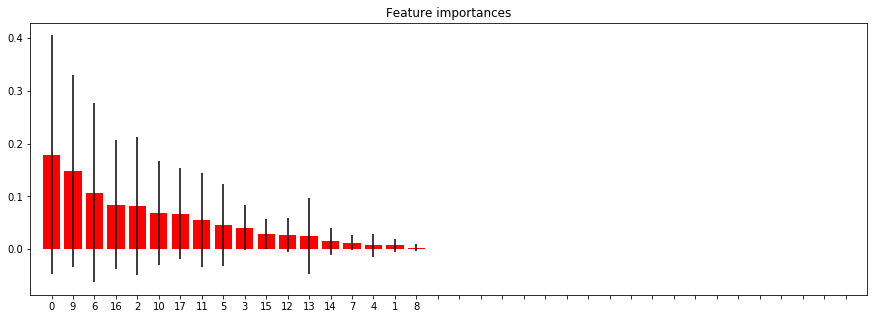

In [44]:
importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, X.columns[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize = (15,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()